## Training test
### A notebook for prototyping mps training code


In [1]:
import numpy as np
import torch

from mps.models import MPS, ComplexTensor
from mps.utils import train_from_dict, rolling_avg
import matplotlib.pyplot as plt
import datetime


Loaded libmkl_rt.so for dgesvd


Pick system size, dimensionality of local hilbert space, and initial bond dim

In [2]:
L=6
local_dim=2
bond_dim=2

In [3]:
# dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dev = torch.device("cpu")

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:
psi.to(device=dev)

In [6]:
fname_settings = "datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
fname_mps = "datasets/mps_sampled/ghz_plus_L=%d_state"%L
Nsamp=20000


In [7]:
training_settings=dict(batch_size=512,epochs=2,
                        max_sv=10,cutoff=1e-3,
                       lr_scale=1e-3, lr_timescale=100,
                       s2_scale=0, s2_timescale=100,
                       hold_early_cutoff=True,
                       wait_for_plateau=True,
                      mps_path = fname_mps, 
                      samples_per_epoch=5)
                           

In [8]:
model, logdict, meta = train_from_dict(fname_samples, fname_settings, training_settings,
                                   N=Nsamp,
                                   use_cache=True, record_eigs=False,record_s2=True,verbose=True,
                                   compute_overlaps=False)

Successfully loaded 20000 settings, samples for system of size L=6
Loaded the following settings:
lr_scale = 1.000000e-03
lr_timescale = 1.000000e+02
s2_scale = 0.000000e+00
s2_timescale = 1.000000e+02
epochs = 2.000000e+00
cutoff = 1.000000e-03
max_sv = 1.000000e+01
batch_size = 5.120000e+02
Hold early cutoff: True
Wait for plateau: True
Samples per epoch: 5
loading ground truth MPS from  datasets/mps_sampled/ghz_plus_L=6_state
Training on system size 6 with 20000 samples
Finished epoch 1 in 1.923 sec
Model shape:  [(1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)]
Finished epoch 2 in 1.941 sec
Model shape:  [(1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)]
Finished epoch 3 in 1.982 sec
Model shape:  [(1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)]
Finished epoch 4 in 1.938 sec
Model shape:  [(1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)]
Finished epoch 5 in 1.944 sec
Model shape:  [(1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)]
Finished epoch 6 in 1.958 sec
Model shape:  [(1, 2), (2, 

In [9]:
fidelity = logdict['fidelity_mps']
loss = logdict['loss']
max_bond_dim = logdict['max_bond_dim']
smooth_loss = rolling_avg(loss,window=10*5)
# eigs = logdict['eigenvalues']
# s2 = logdict['s2']
# val_loss = logdict['val_loss']
# overlap = logdict['overlap']

Text(0.5,1,'batch NLL loss')

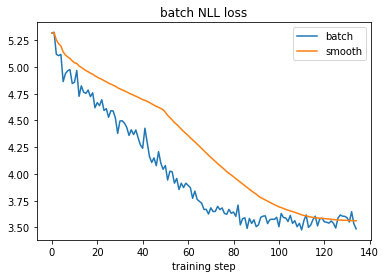

In [10]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(loss, label='batch')
plt.plot(smooth_loss, label='smooth')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss")


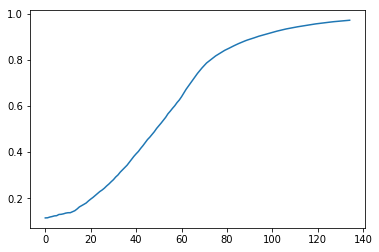

In [11]:
fig, ax = plt.subplots()
plt.plot(fidelity)

In [12]:
fidelity[-1]

0.9717932217128988